In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import sys
sys.path.insert(1, 'scripts/')
from gen_matrix import matrix_gen, get_ICA
from get_sample import get_sample, create_strings_for_dataset
from fft import fft_for_sample
from tqdm import tqdm
import collections
%matplotlib inline

In [2]:
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
import operator

In [5]:
import mne

In [6]:
tmin, tmax = -1., 4.
event_id = dict(hands=2, feet=3)
subject = 1
runs = [6, 10, 14]

In [7]:
raw_fnames = ['data/S001R06.edf',
              'data/S001R10.edf',
              'data/S001R14.edf']

In [8]:
def get_class_eeg(raw_name_path, name):
    raw0 = read_raw_edf(raw_name_path, preload=True)
    eegbci.standardize(raw0)
    montage = make_standard_montage('standard_1005')
    raw0.set_montage(montage)
    raw0.rename_channels(lambda x: x.strip('.'))
    raw0.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')
    
    eeg1 = raw0.get_data()
    
    with open(f'data/S001/{name}_onsets_start.txt', 'r') as fin:
        start = list(map(lambda x: float(x.strip('\n')), fin.readlines()))
    
    with open(f'data/S001/{name}_onsets_end.txt', 'r') as fin:
        end = list(map(lambda x: float(x.strip('\n')), fin.readlines()))

    with open(f'data/S001/{name}_labels.txt', 'r') as fin:
        labels = list(map(lambda x: int(x.strip('\n')), fin.readlines()))
        
    one_colums_sec = end[-1] / eeg1.shape[1]
    
    eeg1_0 = np.zeros((64, 20000))
    eeg1_1 = np.zeros((64, 20000))
    eeg1_2 = np.zeros((64, 20000))

    for s,e,l in zip(start, end, labels):
        columns_start = round(s / one_colums_sec)
        columns_end = round(e / one_colums_sec)
        
        if columns_start == 1:
            columns_start -= 1

        if l == 0:
            eeg1_0[:, columns_start:columns_end] = eeg1[:, columns_start:columns_end]
        elif l == 1:
            eeg1_1[:, columns_start:columns_end] = eeg1[:, columns_start:columns_end]
        elif l == 2:
            eeg1_2[:, columns_start:columns_end] = eeg1[:, columns_start:columns_end]

            
    eeg1_0  = pd.DataFrame(eeg1_0)
    eeg1_1 = pd.DataFrame(eeg1_1)
    eeg1_2 = pd.DataFrame(eeg1_2)

    eeg1_0 = eeg1_0.loc[:, (eeg1_0 != 0).any(axis=0)]
    eeg1_1 = eeg1_1.loc[:, (eeg1_1 != 0).any(axis=0)]
    eeg1_2 = eeg1_2.loc[:, (eeg1_2 != 0).any(axis=0)]
    
    return eeg1_0, eeg1_1, eeg1_2

In [9]:
eeg1_0, eeg1_1, eeg1_2 = get_class_eeg(raw_fnames[0], 'S001R06')
eeg2_0, eeg2_1, eeg2_2 = get_class_eeg(raw_fnames[1], 'S001R10')
eeg3_0, eeg3_1, eeg3_2 = get_class_eeg(raw_fnames[2], 'S001R14')

Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 sec)

Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999

In [10]:
print(eeg1_0.shape, eeg1_1.shape, eeg1_2.shape)
print(eeg2_0.shape, eeg2_1.shape, eeg2_2.shape)
print(eeg3_0.shape, eeg3_1.shape, eeg3_2.shape)

(64, 10120) (64, 4612) (64, 5268)
(64, 10120) (64, 4609) (64, 5271)
(64, 10120) (64, 4611) (64, 5269)


In [11]:
print(eeg1_0.shape[1] + eeg1_1.shape[1] + eeg1_2.shape[1],
eeg2_0.shape[1] + eeg2_1.shape[1] + eeg2_2.shape[1],
eeg2_0.shape[1] + eeg2_1.shape[1] + eeg2_2.shape[1])

20000 20000 20000


In [12]:
eeg_class0 = pd.concat([eeg1_0, eeg2_0, eeg3_0], axis=1)
eeg_class1 = pd.concat([eeg1_1, eeg2_1, eeg3_1], axis=1)
eeg_class2 = pd.concat([eeg1_2, eeg2_2, eeg3_2], axis=1)

In [13]:
class_0 = eeg_class0.shape[1]
class_1 = eeg_class1.shape[1]
class_2 = eeg_class2.shape[1]

In [14]:
EEG = pd.concat([eeg_class0, eeg_class1, eeg_class2], axis=1)
EEG.shape

(64, 60000)

In [15]:
EEG.columns = list(map(lambda x: str(x), np.arange(0, 60000)))

In [16]:
matrix = EEG
size = matrix.shape
class_0 = eeg_class0.shape[1]
class_1 = eeg_class1.shape[1]
class_2 = eeg_class2.shape[1]


CHANALS = 64
N_COMPONENTS_PCA = 60
FREQ = 160

TIME_SEC = 373.5

TIME_SIZE_SEC = 2
STEP_TIME_SEC = 1

SAMPLE_SIZE = TIME_SIZE_SEC * FREQ
STEP_TIME = STEP_TIME_SEC * FREQ

LINSPACE = 0, TIME_SEC, FREQ*TIME_SEC

In [17]:
matrix.shape

(64, 60000)

In [18]:
from sklearn.decomposition import FastICA

FastICA = FastICA(n_components=CHANALS).fit(matrix.T)
ICA = FastICA.transform(matrix.T)


In [19]:
matrix = ICA.T

In [20]:
matrix

array([[-6.35517872e-07,  7.82859606e-04,  1.21776180e-03, ...,
         7.26753139e-06,  3.90656875e-06, -6.35517872e-07],
       [-2.15757151e-07,  2.57164766e-05,  6.51709146e-04, ...,
        -2.91339387e-05, -1.38543896e-05, -2.15757151e-07],
       [ 8.20311160e-07, -3.89372184e-03, -4.03365816e-03, ...,
        -2.32019092e-05, -1.12980698e-05,  8.20311160e-07],
       ...,
       [-1.81109658e-07, -5.00834183e-03, -7.04121900e-03, ...,
         3.99353864e-05,  2.00848724e-05, -1.81109658e-07],
       [ 4.15921105e-07, -5.12331683e-03, -6.70687128e-03, ...,
         4.15624536e-06,  2.04024253e-06,  4.15921105e-07],
       [ 5.38495351e-07,  1.51507753e-04, -6.88348512e-05, ...,
         3.62541150e-05,  1.88447587e-05,  5.38495351e-07]])

In [21]:
matrix_class1 = matrix[:, 0:class_0]
matrix_calss2 = matrix[:, class_0:class_0+class_1]
matrix_calss3 = matrix[:, class_0+class_1:class_0+class_1+class_2]
#Получаем семплы для каждого класса
sample_calss1 = get_sample(matrix_class1, sample_size=SAMPLE_SIZE, step=STEP_TIME)
sample_calss2 = get_sample(matrix_calss2, sample_size=SAMPLE_SIZE, step=STEP_TIME)
sample_calss3 = get_sample(matrix_calss3, sample_size=SAMPLE_SIZE, step=STEP_TIME)


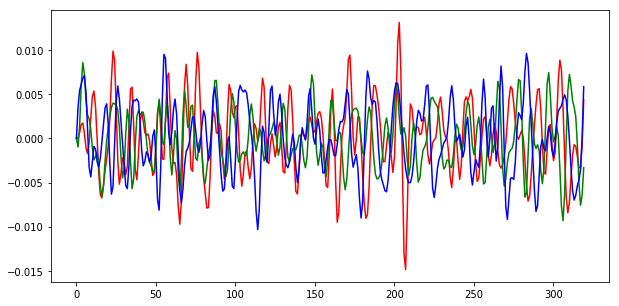

In [22]:
plt.figure(figsize=(10,5))
plt.plot(sample_calss1[0][1], c='r')
plt.plot(sample_calss1[0][10], c='g')
plt.plot(sample_calss1[0][30], c='b')
plt.show()

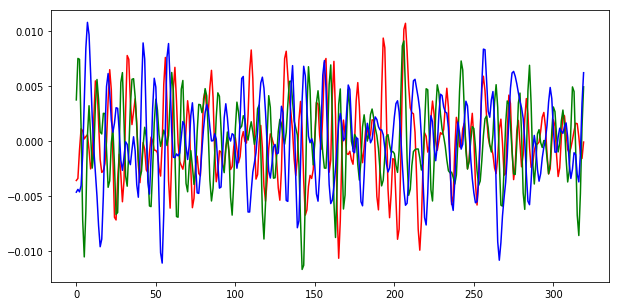

In [23]:
plt.figure(figsize=(10,5))
plt.plot(sample_calss1[10][2], c='r')
plt.plot(sample_calss1[10][3], c='g')
plt.plot(sample_calss1[10][4], c='b')
plt.show()

In [24]:
i_ = 0
for i in range(len(sample_calss1)):
    for j in range(sample_calss1[0].shape[0]):
        #print(sample_calss1[i][j].shape[0])
        if sample_calss1[i][j].shape[0] != SAMPLE_SIZE:
            if i_ == 0:
                i_ = i

In [25]:
sample_calss1 = sample_calss1[:i_]
sample_calss2 = sample_calss2[:i_]
sample_calss3 = sample_calss3[:i_]

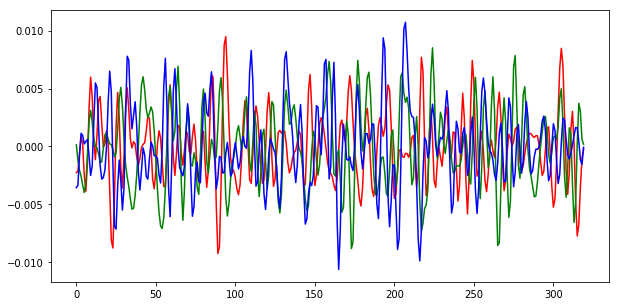

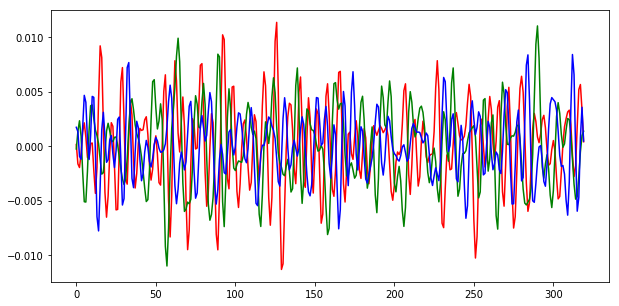

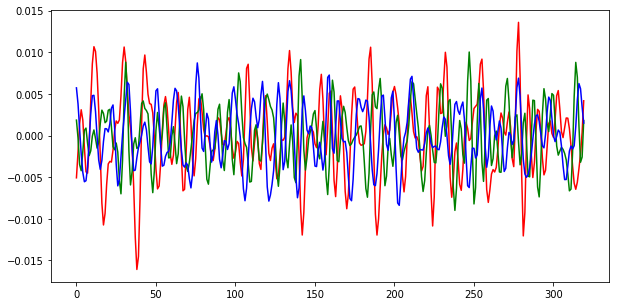

In [26]:
plt.figure(figsize=(10,5))
plt.plot(sample_calss1[10][0], c='r')
plt.plot(sample_calss1[10][1], c='g')
plt.plot(sample_calss1[10][2], c='b')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss2[10][3], c='r')
plt.plot(sample_calss2[10][4], c='g')
plt.plot(sample_calss2[10][0], c='b')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss3[10][1], c='r')
plt.plot(sample_calss3[10][3], c='g')
plt.plot(sample_calss3[10][4], c='b')
plt.show()

In [27]:
samples_fft = list(fft_for_sample(sample_calss1 + sample_calss2 + sample_calss3, freq=FREQ, lowFreq=7, highFreq=30))


In [28]:
len(sample_calss1)

188

In [29]:
len_class_1 = len(sample_calss1)
len_class_2 = len(sample_calss2)
len_class_3 = len(sample_calss3)

sample_calss1_fft = samples_fft[:len_class_1]
sample_calss2_fft = samples_fft[len_class_1:len_class_1 + len_class_2]
sample_calss3_fft = samples_fft[len_class_1 + len_class_2:len_class_1 + len_class_2 + len_class_3]

In [30]:
FIRST_N_FFT = len(sample_calss1_fft[0][0])

In [31]:
FIRST_N_FFT

73

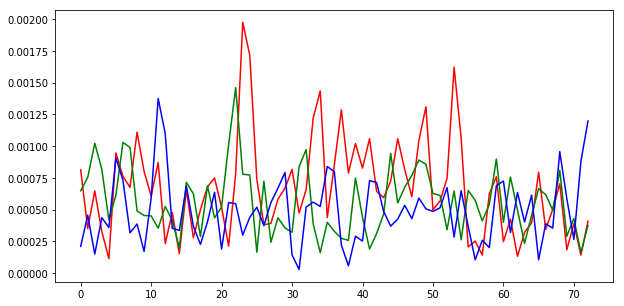

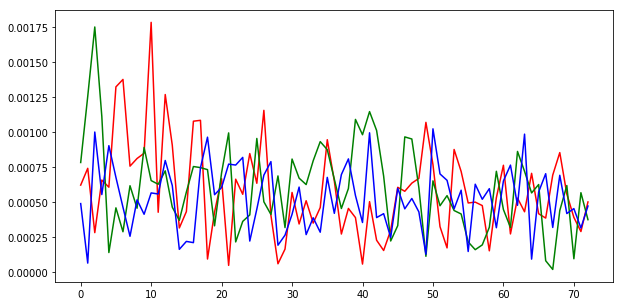

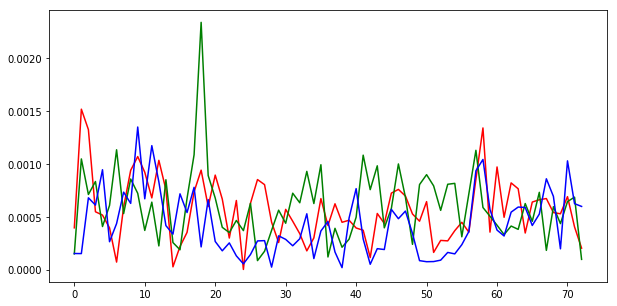

In [32]:
plt.figure(figsize=(10,5))
plt.plot(sample_calss1_fft[10][10], c='r')
plt.plot(sample_calss1_fft[10][12], c='g')
plt.plot(sample_calss1_fft[10][13], c='b')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss2_fft[10][10], c='r')
plt.plot(sample_calss2_fft[10][12], c='g')
plt.plot(sample_calss2_fft[10][13], c='b')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss3_fft[10][10], c='r')
plt.plot(sample_calss3_fft[10][12], c='g')
plt.plot(sample_calss3_fft[10][13], c='b')
plt.show()

In [33]:
for i in range(len(sample_calss1_fft)):
    for j in range(sample_calss1_fft[0].shape[0]):
        sh = sample_calss1_fft[i][j].shape[0]
        if sh != FIRST_N_FFT:
            print(sh)

In [34]:
#Создание строк для датасета, из матрицы CHANALS*FIRST_N_FFT -> в вектор
sample_calss1_fft_str = create_strings_for_dataset(sample_calss1_fft)
sample_calss2_fft_str = create_strings_for_dataset(sample_calss2_fft)
sample_calss3_fft_str = create_strings_for_dataset(sample_calss3_fft)

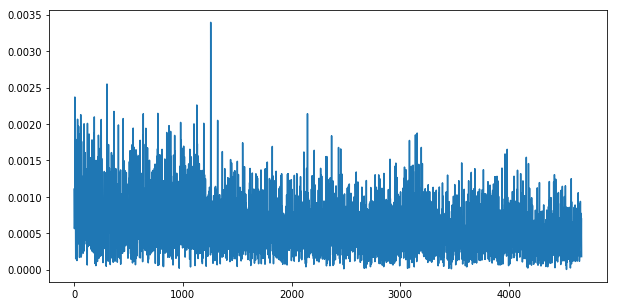

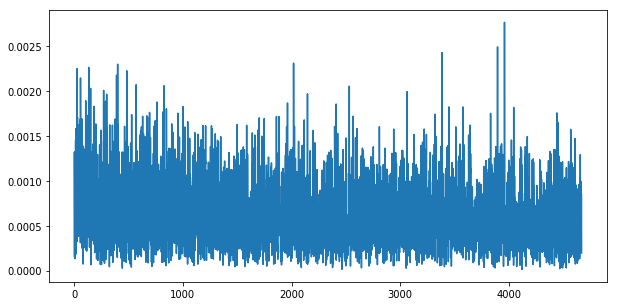

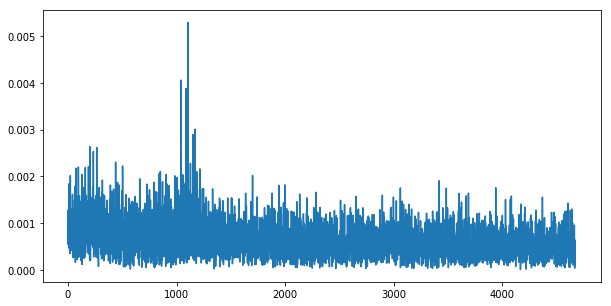

In [35]:
plt.figure(figsize=(10,5))
plt.plot(sample_calss1_fft_str[0])
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss2_fft_str[0])
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss3_fft_str[0])
plt.show()

In [36]:
#Создание таблицы объекты-признаки

#Класс 1
data_class_1 = pd.DataFrame(data=np.zeros((len_class_1, size[0] * FIRST_N_FFT)))
data_class_1['label'] = 1

data_class_1 = np.array(data_class_1)

for i in tqdm(range(len(sample_calss1_fft_str))):
    data_class_1[i, :-1] = sample_calss1_fft_str[i]
    
    
#Класс 2
data_class_2 = pd.DataFrame(data=np.zeros((len_class_2 - 3, size[0] * FIRST_N_FFT))) #!!!!!!
data_class_2['label'] = 2

data_class_2 = np.array(data_class_2)

for i in tqdm(range(len(sample_calss2_fft_str) - 3)): #!!!!!!!!!
    data_class_2[i, :-1] = sample_calss2_fft_str[i]
    
    
#Класс 3
data_class_3 = pd.DataFrame(data=np.zeros((len_class_3 - 1, size[0] * FIRST_N_FFT))) #####!!!!!!
data_class_3['label'] = 3

data_class_3 = np.array(data_class_3)

for i in tqdm(range(len(sample_calss3_fft_str) - 1)): #####!!!!
    data_class_3[i, :-1] = sample_calss3_fft_str[i]
    

    

data = np.vstack([data_class_1, data_class_2, data_class_3])
data = pd.DataFrame(data)
print(data.shape)

100%|██████████| 98/98 [00:00<00:00, 3355.58it/s]

(370, 4673)


In [37]:
data.columns = [*data.columns[:-1], 'label']

In [38]:
def scoring_fi(feature_importances):
    above_zero = feature_importances['importance'][:np.sum(feature_importances['importance'] > 0)]
    mean_value = above_zero.mean()
    features_good = above_zero[above_zero > mean_value].index.tolist()
    features_normal = above_zero[above_zero <= mean_value].index.tolist()
    features_bad = [i for i in feature_importances.index.tolist() if i not in features_good and
                    i not in features_normal]
    
    
    features_good = [i for i in features_good if i not in ['[', ']', ',']]
    features_normal = [i for i in features_normal if i not in ['[', ']', ',']]
    features_bad = [i for i in features_bad if i not in ['[', ']', ',']]
    
    features_good = list(map(lambda x: str(x), features_good))
    features_normal = list(map(lambda x: str(x), features_normal))
    features_bad = list(map(lambda x: str(x), features_bad))
    
    
    return features_good, features_normal, features_bad

In [39]:
'''
{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}
'''

"\n{'bootstrap': True,\n 'max_depth': 10,\n 'max_features': 'auto',\n 'min_samples_leaf': 1,\n 'min_samples_split': 2,\n 'n_estimators': 200}\n"

In [40]:

# ###SOLO

# ## Понизим размерность до 60 компонент
# from sklearn.decomposition import PCA
# PCA = PCA(n_components=N_COMPONENTS_PCA, random_state=100)
# #Стандартизируем матрицу
# # Scaler = StandardScaler()
# # data_standart = Scaler.fit_transform((data).iloc[:, :-1])
# data_standart = (data).iloc[:, :-1]
# # Понижаем размерность
# data_pca = PCA.fit_transform(data_standart)
# data_pca = pd.DataFrame(data_pca)

# # data_pca['label'] = data['label'].values
# labels = data['label'].values

# #Посмотрим важные признаки с помощью RF
# # rf = RandomForestClassifier(bootstrap=True, max_depth=10,
# #                            max_features='auto', min_samples_leaf=1,
# #                            min_samples_split=2, n_estimators=200)
# rf = RandomForestClassifier()
# rf.fit(data_pca, labels)

In [41]:

### ANSAMBEL


## Понизим размерность до 60 компонент
from sklearn.decomposition import PCA
PCA = PCA(n_components=N_COMPONENTS_PCA, random_state=100)
#Стандартизируем матрицу
# Scaler = StandardScaler()
# data_standart = Scaler.fit_transform((data).iloc[:, :-1])
data_standart = (data).iloc[:, :-1]

# Понижаем размерность
data_pca = PCA.fit_transform(data_standart)
data_pca = pd.DataFrame(data_pca)

# data_pca['label'] = data['label'].values
labels = data['label'].values


fg = []
fn = []
fb = []
for _ in range(200):
    rf = RandomForestClassifier()
    rf.fit(data_pca, labels)
    feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = data_pca.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
    
    features_good, features_normal, features_bad = scoring_fi(feature_importances)
    fg.extend(features_good)
    fn.extend(features_normal)
    fb.extend(features_bad)

features_good = list(map(lambda x: x[0], sorted(collections.Counter(fg).items(), key=operator.itemgetter(1), reverse=True)[:10]))
features_normal = list(map(lambda x: x[0],
                           sorted(collections.Counter(fn).items(), key=operator.itemgetter(1), reverse=True)))

features_normal = list(set(features_normal) - set(features_good))

features_bad = list(set(fb) - set(features_good) - set(features_normal))

/Users/alexandr/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/alexandr/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/alexandr/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/alexandr/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/alexandr/anaconda3/lib/py

/Users/alexandr/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/alexandr/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/alexandr/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/alexandr/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/alexandr/anaconda3/lib/py

/Users/alexandr/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/alexandr/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/alexandr/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/alexandr/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/alexandr/anaconda3/lib/py

/Users/alexandr/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/alexandr/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/alexandr/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/alexandr/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/alexandr/anaconda3/lib/py

/Users/alexandr/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/alexandr/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/alexandr/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/alexandr/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/alexandr/anaconda3/lib/py

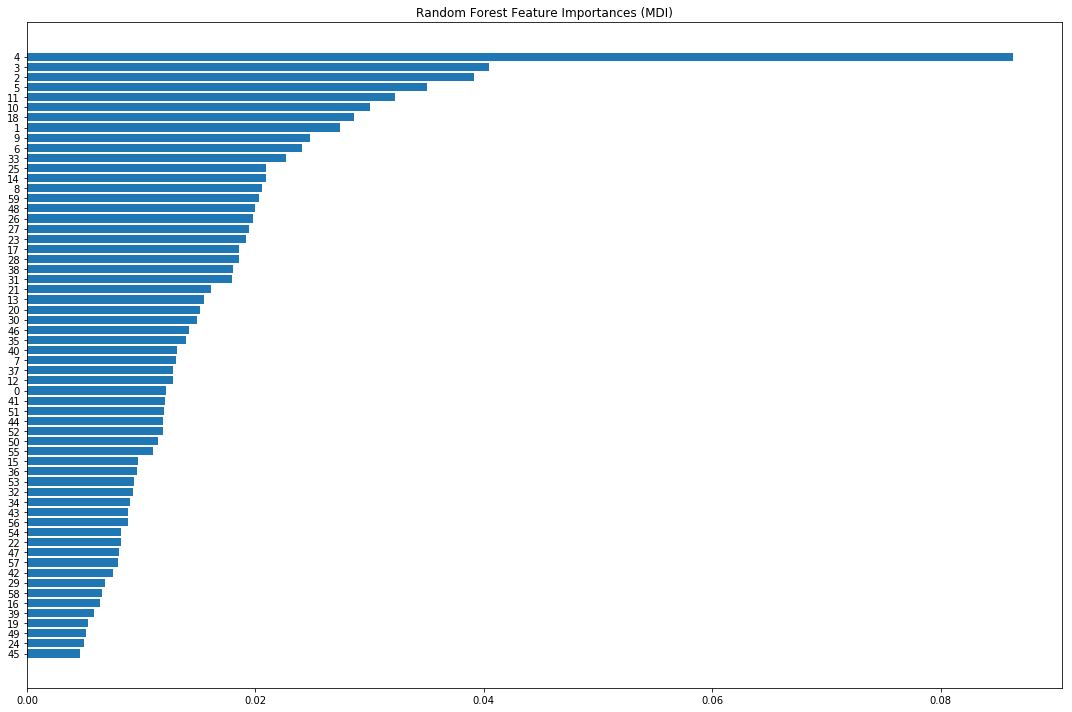

In [42]:
tree_feature_importances = (rf.feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(data_pca.columns))
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(data_pca.columns[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.savefig('RF PCA Feature Importances')
plt.show()

In [43]:
# feature_importances = pd.DataFrame(rf.feature_importances_,
#                                    index = data_pca.columns,
#                                     columns=['importance']).sort_values('importance',ascending=False)

In [44]:
train_features = data_standart
from sklearn.decomposition import PCA
model = PCA(n_components=N_COMPONENTS_PCA, random_state=100).fit(train_features)
X_pc = model.transform(train_features)

#features_good, features_normal, features_bad = scoring_fi(feature_importances)

In [45]:
def features_imp_pca(train_features, model_pca, X_pca, features_good, features_bad, features_normal):
    
    global size, N_COMPONENTS_PCA, FIRST_N_FFT
    
    reward_best = 50
    reward_max = 10
    reward_med = 5
    reward_min = 1
    
    fe_imp = {}
    for feature in range(0, size[1]):
        fe_imp['feature' + '_' + str(feature)] = 0
        
    component_max_list = [abs(pd.DataFrame(model_pca.components_).loc[i, :]).max() for i in range(N_COMPONENTS_PCA)]
    component_mean_list = [abs(pd.DataFrame(model_pca.components_).loc[i, :]).mean() for i in range(N_COMPONENTS_PCA)]
        
    for feature in tqdm(range(0, size[0]*FIRST_N_FFT)):
        reward = 0
        for component in range(0, N_COMPONENTS_PCA):
            feature_value =abs( model_pca.components_[component, feature])
            component_max = component_max_list[component]
            component_mean = component_mean_list[component]
            
            comparison_max = component_max - component_max / 10
            comparison_med = component_max - component_max / 20
            comparison_min = component_mean
            
            
            
            if feature_value >= comparison_min:
                if str(component) in features_bad:
                    reward -= reward_min
                elif str(feature) in features_good or str(feature) in features_normal:
                    reward += reward_min
            
            if feature_value >= comparison_med:
                if str(component) in features_bad:
                    reward -= reward_med
                elif str(component) in features_normal:
                    reward += reward_med
                elif str(component) in features_good:
                    reward += reward_max
            
            if feature_value >= comparison_max:
                if str(component) in features_bad:
                    reward -= reward_max
                elif str(component) in features_normal:
                    reward += reward_max
                elif str(component) in features_good:
                    reward += reward_best #best
                    
            if feature_value <= comparison_min:
                if str(component) in features_bad:
                    reward += reward_min
                elif str(component) in features_good or str(feature) in features_normal:
                    reward -= reward_min
                    
                    
        fe_imp['feature' + '_' + str(feature)] = reward
            
    return fe_imp
            
            
    
    
    

In [46]:
d = features_imp_pca((train_features), model, X_pc, features_good, features_bad, features_normal)

100%|██████████| 4672/4672 [00:00<00:00, 7471.29it/s]


In [47]:
sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
best_features = [sorted_d[i][0] for i in range(5)]

In [48]:
sorted_d[:10]

[('feature_1151', 238),
 ('feature_1107', 155),
 ('feature_920', 109),
 ('feature_1171', 94),
 ('feature_856', 90),
 ('feature_1023', 79),
 ('feature_1215', 79),
 ('feature_1148', 75),
 ('feature_1087', 74),
 ('feature_694', 72)]

In [49]:
sorted_d[-15:]

[('feature_4662', -10),
 ('feature_4663', -10),
 ('feature_4664', -10),
 ('feature_4671', -10),
 ('feature_13', -12),
 ('feature_16', -12),
 ('feature_17', -12),
 ('feature_43', -14),
 ('feature_54', -14),
 ('feature_24', -18),
 ('feature_19', -20),
 ('feature_25', -24),
 ('feature_34', -24),
 ('feature_40', -24),
 ('feature_51', -26)]

In [50]:
### Главные признаки, с которыми будем рабоать 
train_features = pd.DataFrame(train_features)
for number_feature in list(best_features):
    number_feature = int(number_feature.split('_')[1])
    train_features.iloc[:, number_feature] = train_features.iloc[:, number_feature].apply(lambda x: str(x) +
                                                                                          '_FE').values

# train_features.iloc[:, 1669] = train_features.iloc[:, 1669].apply(lambda x: str(x) + '_FE').values

In [51]:
### Восстановим исходный вид таблицы, а именно 128x20x100 (102 в данном примере)

old_table = []
for i in tqdm(range(train_features.shape[0])):
    sample = pd.DataFrame(np.zeros((CHANALS, FIRST_N_FFT)))
    string = train_features.iloc[i, :]
    
    index_start = 0
    index_end = CHANALS

        
    for s in range(FIRST_N_FFT): ##!!!
        sample.iloc[:, s] = string.iloc[index_start : index_end].values
        index_start = index_end
        index_end += CHANALS

        if index_end > size[0]*FIRST_N_FFT:
            break

    old_table.append(sample.values)
  

100%|██████████| 370/370 [00:17<00:00, 21.67it/s]


In [52]:
### Найдем в исходной таблице важный признак

FE_items = []


for table_number, table in tqdm(enumerate(old_table)):
    for column in range(table.shape[1]):
        for idx in range(table.shape[0]):
            if len(str(table[idx, column]).split('_')) > 1:
                FE_items.append((table_number, idx, column))
            
            

370it [00:01, 198.72it/s]


In [53]:
FE_items

[(0, 24, 13),
 (0, 24, 14),
 (0, 19, 17),
 (0, 63, 17),
 (0, 19, 18),
 (1, 24, 13),
 (1, 24, 14),
 (1, 19, 17),
 (1, 63, 17),
 (1, 19, 18),
 (2, 24, 13),
 (2, 24, 14),
 (2, 19, 17),
 (2, 63, 17),
 (2, 19, 18),
 (3, 24, 13),
 (3, 24, 14),
 (3, 19, 17),
 (3, 63, 17),
 (3, 19, 18),
 (4, 24, 13),
 (4, 24, 14),
 (4, 19, 17),
 (4, 63, 17),
 (4, 19, 18),
 (5, 24, 13),
 (5, 24, 14),
 (5, 19, 17),
 (5, 63, 17),
 (5, 19, 18),
 (6, 24, 13),
 (6, 24, 14),
 (6, 19, 17),
 (6, 63, 17),
 (6, 19, 18),
 (7, 24, 13),
 (7, 24, 14),
 (7, 19, 17),
 (7, 63, 17),
 (7, 19, 18),
 (8, 24, 13),
 (8, 24, 14),
 (8, 19, 17),
 (8, 63, 17),
 (8, 19, 18),
 (9, 24, 13),
 (9, 24, 14),
 (9, 19, 17),
 (9, 63, 17),
 (9, 19, 18),
 (10, 24, 13),
 (10, 24, 14),
 (10, 19, 17),
 (10, 63, 17),
 (10, 19, 18),
 (11, 24, 13),
 (11, 24, 14),
 (11, 19, 17),
 (11, 63, 17),
 (11, 19, 18),
 (12, 24, 13),
 (12, 24, 14),
 (12, 19, 17),
 (12, 63, 17),
 (12, 19, 18),
 (13, 24, 13),
 (13, 24, 14),
 (13, 19, 17),
 (13, 63, 17),
 (13, 19, 18),


In [54]:
best_feat = list(map(lambda x: x[0], 
    sorted(collections.Counter(list(map(lambda x: x[1], FE_items))).items(), 
           key=operator.itemgetter(1), reverse=True)))

____

In [55]:
ch = []
for i in best_feat:
    ch.append(np.argmax(np.abs(FastICA.mixing_[:, i])))

print(ch)

[62, 5, 8]


In [56]:
raw_fnames = ['data/S001R06.edf',
              'data/S001R10.edf',
              'data/S001R14.edf']

raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])

Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


In [57]:
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)

# strip channel names of "." characters
raw.rename_channels(lambda x: x.strip('.'))


<RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.5 MB, data loaded>

In [58]:
ch_name_dict = {}

for i in range(0, 64):
    ch_name_dict[i] = raw.ch_names[i]

In [59]:
for i in ch:
    print(ch_name_dict[i])

O2
FC4
C3
